# Projet numérique de Science des Données 2025

__Binôme numéro ### -- LOSANTOS Solène et MICHAUD Baptiste

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

**Intérêts :**
- En délégant à un algorithme, on évite la consultation, il faut juste récupérer les données et informer le patient de son risque. Cela permet dans des régions pauvres où l'accessibilité à la consultation est difficile de toucher un plus grand nombre de patients.

**Dérives:**:
- sociales:
- éthiques :
- économiques :
- psychologiques : 


## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [5]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [6]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

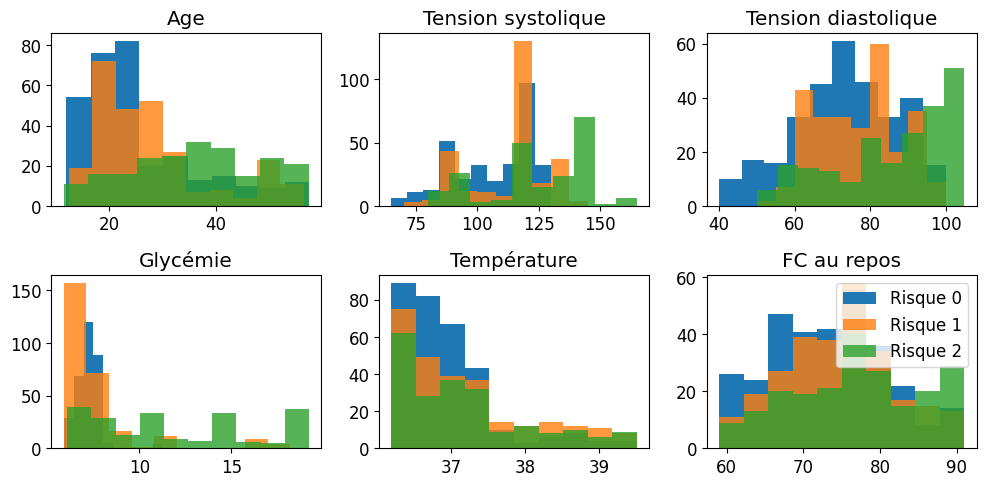

In [16]:
fig = plt.figure(figsize=(10, 5))

# Histogrammes pour les variables continues
for (feat_idx, feat_name) in enumerate(df_train.columns[:6]):
    # créer une sous-figure (subplot) à la position (feat_idx+1) d'une grille 2x5
    ax = fig.add_subplot(2, 3, (feat_idx+1))

    # afficher l'histogramme de la variable feat_name pour Risque = 0
    h = ax.hist(df_train[df_train['Risque']==0][feat_name], bins=10,  
                color='tab:blue', edgecolor='none', alpha=1, label='Risque 0')
    
    # afficher l'histogramme de la variable feat_name pour Risque = 1
    h = ax.hist(df_train[df_train['Risque']==1][feat_name], bins=10,  
                color='tab:orange', edgecolor='none', alpha=0.8, label='Risque 1')
    
     # afficher l'histogramme de la variable feat_name pour Risque = 2
    h = ax.hist(df_train[df_train['Risque']==2][feat_name], bins=10,  
                color='tab:green', edgecolor='none', alpha=0.8, label='Risque 2')

    # utiliser le nom de la variable comme titre pour chaque histogramme
    ax.set_title(feat_name)

# Légende
plt.legend()

# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

Non les valeurs observées ne sont pas surprenantes. En effet :

- **Age** : Les personnes de degré de risque obstétrique 0 et 1 sont majoritairement jeunes (20-30 ans), tandis que celle de degré 3 couvre tout le spectre des âges et notamment l'intervalle 30-50 ans. Cela semble cohérent car la fréquence de diabète augmente avec l'âge (moyenne d'âge des patients diabétiques en France : 67,6 ans)

- **Tension systolique, dyastolique et glycémie** : les valeurs les plus élevées de ces variables sont atteintes par des degrés 3 de risque obstétrique. En effet, le diabète se caractérise par un excès de sucre dans le sang (hyperglycémie) et est souvent associé à l'hypertension car ils possèdent les mêmes facteurs de risque (obésité, manque d'activité physique, mauvaise alimentation, tabagisme). 

- **Température** : il semble difficile d'interpréter les valeurs prises par les trois degrés de risque, mais il semble que les degrés 1 et 2 recouvrent plus les températures 38-39°C que le degré 0 qui est très concentré autour de 36-37°C.

- **Fréquence cardiaque au repos** : à nouveau, les valeurs les plus élevées semblent être majoritairement atteintes par des degrés 3 (85-95 battements/minute), bien que les trois degrés couvrent tout le spectre de fréquence cardiaque. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Il va être **difficile** de prédire le risque de grossesse à risque **en utilisant ces 6 variables** ! Certaines variables semblent mieux séparer les trois degrés de risque (notammenent l'âge, les tensions et la glycémie), tandis que d'autres sont moins évidentes à réellement interpréter (température, FC au repos), la distribution des valeurs n'étant pas concentrée autour d'un intervalle précis mais plutôt étalée sur tout le spectre.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

Text(0, 0.5, 'PC 2')

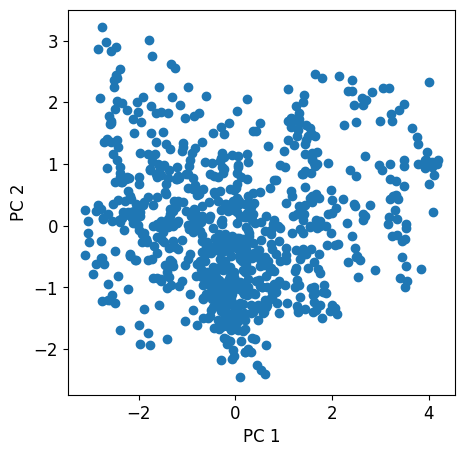

In [ ]:
from sklearn import preprocessing
from sklearn import decomposition

# On standardise les données :

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)

# On calcule les composantes principales et on projette sur les 2 premières PC:

pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_projected = pca.transform(X_train_scaled)

# On affiche un nuage de point représentant les données selon les deux PC :

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1])

plt.xlabel("PC 1")
plt.ylabel("PC 2")


### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Matrice de corrélation entre les 6 variables')

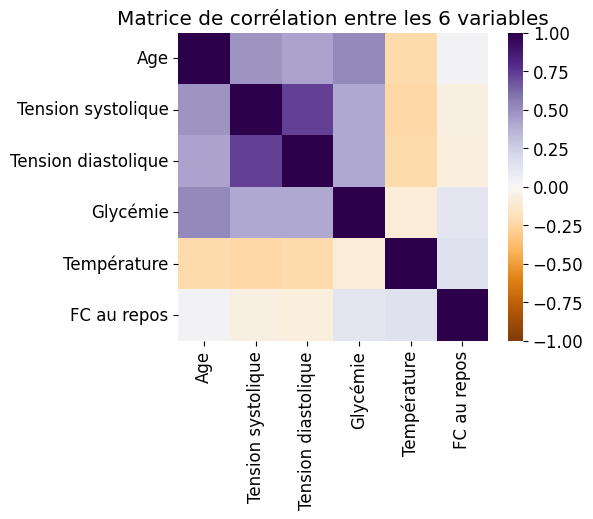

In [18]:
import seaborn as sns

# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Matrice de corrélation entre les 6 variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

Comme nous l'avions observé à la question 3, l'âge, la tension systolique et dyastolique et la glycémie semblent corrélées entre elles (corrélation entre 0.25 et 0.75) tandis que la température et la FC au repos semblent indépendantes des autres variables (corrélation nulle ou négative!). 

**Il peut donc être intéressant d'enlever ces deux variables pour réduire la dimension des données.**

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [ ]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')


,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,1
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

L'*accuracy* de ce modèle correspondrait exactement à la proportion de la classe majoritaire dans les données. 

$$\text{Accuracy} = \frac{\text{Nombre d'observations correspondant à la classe majoritaire}}{\text{Nombre d'observations total}}$$

Cela serait très embêtant dans le cadre de notre modèle. Si les degrés de risque 1 ou 2 sont plus rares que le degré de type 0, le modèle prédira que toutes les femmes enceintes ont un risque obstrétique de degré 0 indépendemment des données médicales récupérées (âge, tensions, glycémie..). 

**Le modèle sera donc incapable de se servir des données pour prédire correctement le risque. Pourtant, il aura une accuracy élevé!**

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

La précision équilibré est la moyenne arithmétique du **rappel** (taux de vrais positifs = proportion d’exemples positifs correctement identifiés comme tels) et de la **spécifité** (taux de vrais négatifs = proportion d'exemples négatifs correctement identifiés comme tels).

Ce critère d'évalution est plus pertinent car il met au même niveau les vrais positifs et les vrais négatifs. 
En effet, en reprenant l'exemple du modèle de la question 9, soit la spécifité du modèle sera nulle (aucun vrai négatif car toutes les observations seront qualifiées de positives), soit le rappel sera nul (aucun vrai positif car toutes les observations seront qualifiées de négatives). Cela réduira considérablement la précision équilibrée et montrera que le modèle ne prédit pas à partir des données. 

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [41]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train_risk_vs_norisk )

predict=neigh.predict(X_train)
n= predict.size
TP,FN,TN,FP=(0,0,0,0)
for i in range(n):
        if predict[i]==0 and y_train_risk_vs_norisk[i]==0:
            TN+=1
        elif predict[i]==0 and y_train_risk_vs_norisk[i]==1:
            FN+=1
        elif predict[i]==1 and y_train_risk_vs_norisk[i]==1:
            TP+=1
        elif predict[i]==1 and y_train_risk_vs_norisk[i]==0:
            FP+=1
print(TP,FN,TN,FP)

BA=1/2*(TP/(TP+FN)+TN/(TN+FP))
print(BA)

430 54 265 51
0.8635186735014123


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [55]:
from sklearn import model_selection

# Définir la grille de valeurs de l'hyperparamètre K
K_values = list(range(1,16,1))

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(KNeighborsClassifier(), {'n_neighbors': K_values}, 
                                          cv=10, # on demande à définir 10 folds
                                          scoring='neg_root_mean_squared_error'
                                         )

# Utiliser la recherche sur grille
grid.fit(X_train, y_train_risk_vs_norisk)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             scoring='neg_root_mean_squared_error')

In [58]:
#Détails des calculs effectués par fit :
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

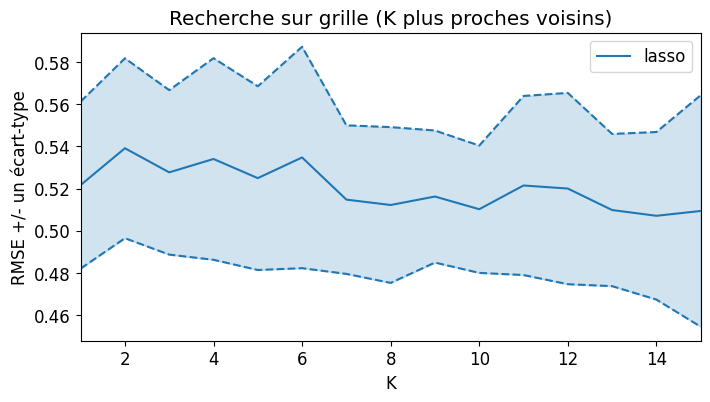

In [61]:
#Représentation sur une figure :
plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.plot(grid.cv_results_['param_n_neighbors'], rmses, 
             label="lasso", color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], rmses + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], rmses - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(K_values, (rmses + std_error), (rmses - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("K")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([K_values[0], K_values[-1]])
plt.title("Recherche sur grille (K plus proches voisins)")
plt.legend(loc='best')

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.